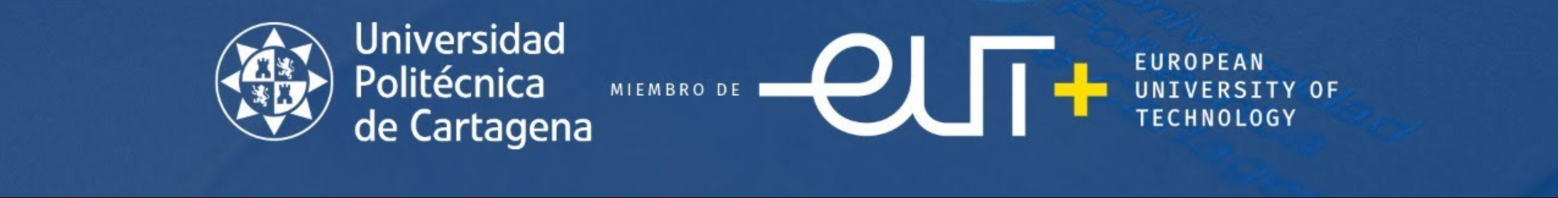

**MACHINE LEARNING II**

# PRÁCTICA 3: SESIÓN 2 - SISTEMAS DE REGLAS DIFUSAS


Los objetivos de aprendizaje de esta práctica son:
1) Comprender las relaciones borrosas entre conjuntos difusos.
2) Comprender el funcionamiento de los sistemas de reglas fuzzy.
3) Aplicar estos conocimientos a problemas prácticos.

## 1. Recordatorios

### 1.1 Conjuntos fuzzy con `skfuzzy`

En la anterior sesión de prácticas aprendimos a utilizar la librería `skfuzzy` para definir conjuntos difusos. Hoy vamos a importar también el módulo `control`.

In [1]:
# Descomentar este código para instalar las librerías en caso de no tenerlas ya
%pip install numpy
%pip install -U scikit-fuzzy

#Implemente las librerías mencionadas
import numpy as np
import skfuzzy as fuzz
import skfuzzy.control as ctrl

import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894077 sha256=370e538edfaedae9c1382463392bbc6dd5000ad248c313e66d512aeca89f3390
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy


Como ya sabe, los conjuntos difusos sirven para modelar situaciones en los que un criterio no está totalmente definido. Por ejemplo, no existe un criterio exacto que delimite el considerar una cosa como fría, templada o caliente, lo que modelaremos como grados de pertenencia a esos conjuntos.

Utilizamos la librería para crear la distintas funciones de pertencencia de los conjuntos difusos, y las operaciones entre ellos las hacemos operando directamente sobre los valores de dichas funciones con `numpy`.

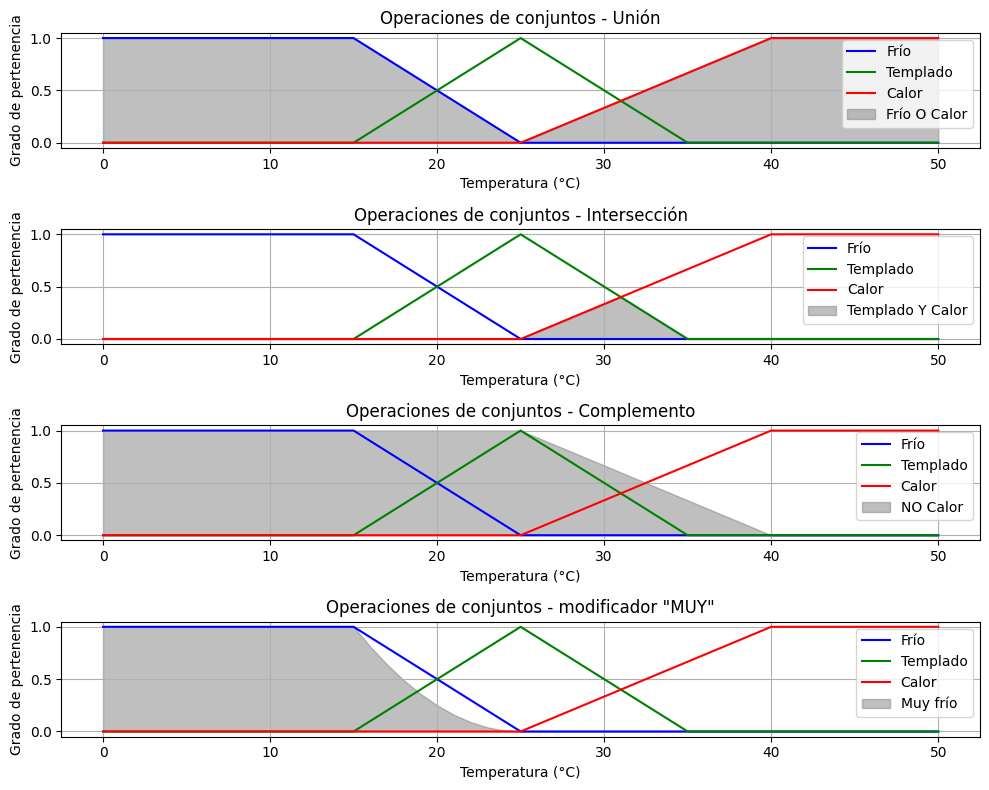

In [2]:
# Definición del rango del dominio, en este ejemplo la temperatura ambiente (0°C a 50ºC)
temperatura = np.arange(0, 51, 1)

frio     = fuzz.trapmf(temperatura,[0,0,15,25])
templado = fuzz.trapmf(temperatura,[15,25,25,35])
caliente = fuzz.trapmf(temperatura,[25,40,50,50])

# Para la unión de conjuntos utilizamos el máximo
frio_o_caliente = np.fmax(frio,caliente)

# Para la intersección de conjuntos utilizaremos el mínimo
templado_y_caliente = np.fmin(templado, caliente)

# Para el complemento utilizamos 1 - cjto:
no_caliente = 1 - caliente

# Para aplicar modificadores lingüísticos aplicamos su definición directamente dobre los puntos
muy_frio = np.power(frio,2)

# Visualizar las operaciones
plt.figure(figsize=(10, 8))

plt.subplot(4, 1, 1)
plt.plot(temperatura, frio, 'b', label='Frío')
plt.plot(temperatura, templado, 'g', label='Templado')
plt.plot(temperatura, caliente, 'r', label='Calor')
plt.fill_between(temperatura, frio_o_caliente, color='gray', alpha=0.5, label="Frío O Calor")
plt.title('Operaciones de conjuntos - Unión')
plt.xlabel('Temperatura (°C)')
plt.ylabel('Grado de pertenencia')
plt.legend()
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(temperatura, frio, 'b', label='Frío')
plt.plot(temperatura, templado, 'g', label='Templado')
plt.plot(temperatura, caliente, 'r', label='Calor')
plt.fill_between(temperatura, templado_y_caliente, color='gray', alpha=0.5, label="Templado Y Calor")
plt.title('Operaciones de conjuntos - Intersección')
plt.xlabel('Temperatura (°C)')
plt.ylabel('Grado de pertenencia')
plt.legend()
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(temperatura, frio, 'b', label='Frío')
plt.plot(temperatura, templado, 'g', label='Templado')
plt.plot(temperatura, caliente, 'r', label='Calor')
plt.fill_between(temperatura, no_caliente, color='gray', alpha=0.5, label="NO Calor")
plt.title('Operaciones de conjuntos - Complemento')
plt.xlabel('Temperatura (°C)')
plt.ylabel('Grado de pertenencia')
plt.legend()
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(temperatura, frio, 'b', label='Frío')
plt.plot(temperatura, templado, 'g', label='Templado')
plt.plot(temperatura, caliente, 'r', label='Calor')
plt.fill_between(temperatura, muy_frio, color='gray', alpha=0.5, label="Muy frío")
plt.title('Operaciones de conjuntos - modificador "MUY"')
plt.xlabel('Temperatura (°C)')
plt.ylabel('Grado de pertenencia')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### 1.2 Sistemas de reglas fuzzy

Recuerde que un sistema de reglas fuzzy (FIS, Fuzzy Inference System) es un tipo particular de sistema basado en reglas, donde se utiliza la lógica fuzzy para razonar.

El funcionamiento de estos sistemas se basa en cuatro etapas:

  1. **Fuzzificación**: Se calcula la pertenencia a conjuntos difusos de las entradas.
  2. **Evaluación de reglas**: Se calculan los niveles de activación de cada regla en base a las entradas.
  3. **Agregación de salida de las reglas**: Se agregan los conjuntos de salida de cada regla.
  4. **Defuzzificación**: Se calcula el valor CRISP resultante a partir de los conjuntos difusos obtenidos.

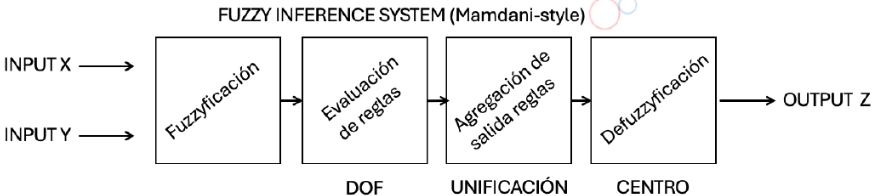

## 2. Sistemas de reglas con `skfuzzy`

### 2.1. Definición del problema ejemplo: Llenado de depósito

La librería `skfuzzy` nos permite definir los FIS de manera muy sencilla a partir del módulo `control`. Para mostrar la manera de trabajar con este módulo vamos a construir un sistema sencillo para el siguiente problema:

Supongamos que tenemos un depósito de 100 L que vamos a llenar de agua. Tenemos un sensor que nos mide el volumen llenado y otro que mide el caudal de llenado en L/min., con unas velocidades desde 0 a 10 L/min. Nuestro controlador tendrá como entrada el volumen que ya se ha llenado del depósito, y como salida el caudal de agua a suministrar.

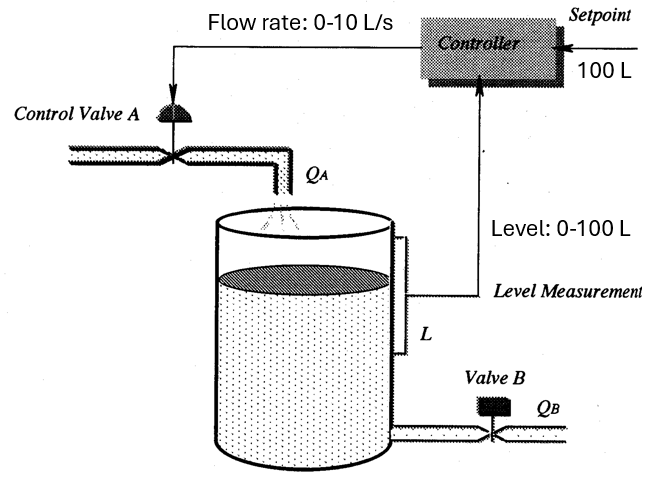

<small>_Imagen basada en material de clase de Roque Marín - 2006_</small>



Las reglas a implementar serían:

- Si el depósito tiene poca agua, enviar un caudal alto.
- Si el depósito está sobre la mitad, enviar un caudal moderado.
- Si el depósito mucha agua, enviar un caudal bajo.

### 2.2. Definición de conjuntos difusos de entradas y salidas

Lo primero es definir los rangos de los universos que vamos a utilizar en nuestro problema. En este caso, serían:
- El nivel del depósito en litros, de 0 a 100.
- El caudal en l/min, de 0 a 10. Como es un rango muy pequeño, lo podemos definir con un paso de 0.5 l/min para mayor precisión.

In [3]:
# Definimos los rangos de nivel de agua y de caudal
nivel  = np.arange(0, 101, 1)
caudal = np.arange(0, 10.5, 0.5) # Variaremos con un step de 0.5 para una mayor granularidad

Seguidamente definimos los conjuntos difusos que tenemos en nuestras reglas. Con respecto al nivel trendremos _nivel alto_ (mucha agua), _nivel medio_ (sobre la mitad) y _nivel bajo_ (poca agua). Y con respecto al caudal, de manera similar, un _caudal bajo_, _caudal medio_ y _caudal alto_.

Podemos utilizar funciones triangulares sencillas para cada conjunto. Supungamos que los niveles "bajo" y "alto" terminan y comienzan respectivamente en la mitad de los rangos, y el valor "medio" comienza al principio de rango, llega al máximo justo a mitad, y vuelve a 0 al final del rango.

In [4]:
# Definimos las funciones de pertenencia de cada nivel
nivel_bajo  = fuzz.trimf(nivel,[0,0,50])
nivel_medio = fuzz.trimf(nivel,[0,50,100])
nivel_alto  = fuzz.trimf(nivel,[50,100,100])

**A completar por el/la alumno/a:**: Defina de forma similar las funciones de pertencia para `caudal_bajo`, `caudal_medio` y `caudal_alto`.

In [5]:
# Definimos las funciones de pertenencia para cada rango de caudal
caudal_bajo  = 
caudal_medio = 
caudal_alto  = 

### 2.3. Definición de las entradas y salidas (antecedentes y consecuentes de las reglas)

Lo siguiente sería definir cuáles van a ser las entradas del sistema, que se corresponderán con los valores que vamos a manejar en los antecedentes de nuestras reglas.

En este caso, tan solo tenemos el nivel del depósito. Para definirlo, utilizamos la función `Antecedent` del módulo `control`. Tiene dos parámetros:

   - El universo (rango de valores posible) sobre el que definimos la entrada.
   - Una etiqueta que nos servirá para nombrar esta entrada.

In [6]:
# Nuestras reglas tendrán un solo antecedente, que será el nivel de agua
nivel_entrada = ctrl.Antecedent(nivel, 'nivel')

De forma similar, se define la salida, que sería únicamente el caudal a obtener. En este caso se utiliza la función `Consequent`, con parámetros similares:

In [7]:
# Nuestras reglas tendrán un solo consecuente, que será el caudal a generar
caudal_salida = ctrl.Consequent(caudal, 'caudal')

Lo siguiente a realizar sería asignar una función de pertenencia a cada conjunto difuso que vayamos a utilizar como antecedente o consecuente de una regla. Se realizará utilizando el objeto obtenido de la llamada a `Antecedent`/`Consequent` como si fuera un array. Como ya los tenemos definidos anteriormente, sólo es necesario asignarlos:

In [8]:
# Hay que asociar a cada etiqueta lingüística su correspondiente función de pertenencia
nivel_entrada['bajo']  = nivel_bajo
nivel_entrada['medio'] = nivel_medio
nivel_entrada['alto']  = nivel_alto

caudal_salida['bajo']  = caudal_bajo
caudal_salida['medio'] = caudal_medio
caudal_salida['alto']  = caudal_alto

Podemos visualizar los conjuntos definidos en los antecedentes y consecuentes utilizando el método `.view()` de los mismos (sin indicar más parámetros):

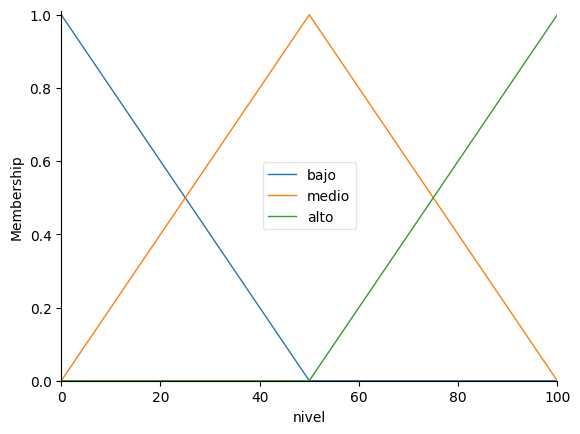

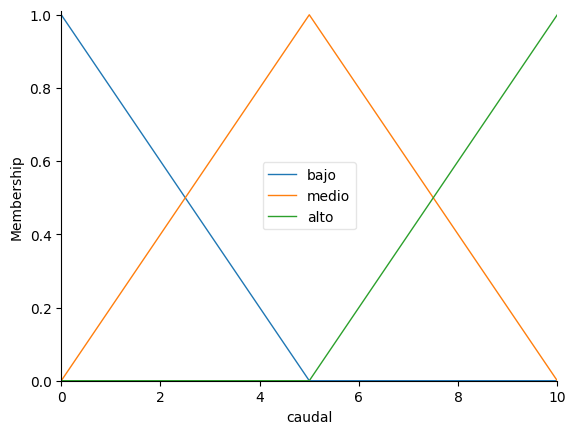

In [9]:
nivel_entrada.view()
caudal_salida.view()

### 2.4 Definición de las reglas del sistema

Lo siguiente sería crear las reglas que tendrá nuestro sistema. Para ello utilizamos la función `Rule`, cuyos parámetros son:
  - Antecedente de la regla: Términos de tipo `Antecedent`. Pueden combinarse utilizando | (or), & (and) o bien ~ (not).
  - Consecuente de la regla: Términos de tipo `Consequent`. Pueden combinarse utilizando | (or), & (and) o bien ~ (not).

En nuestro caso, las reglas son muy sencillas y no hay combinaciones de consecuentes y demás, así que podemos definirlas de la siguiente manera:

In [10]:

# Definimos nuestras reglas en función de las etiquetas lingüisticas
regla1 = ctrl.Rule(nivel_entrada['bajo'], caudal_salida['alto'])
regla2 = ctrl.Rule(nivel_entrada['medio'], caudal_salida['medio'])
regla3 = ctrl.Rule(nivel_entrada['alto'], caudal_salida['bajo'])

### 2.5 Creación del sistema de control

Ya tenemos todos los elementos de nuestro sistema de control. Solo nos queda crearlo, lo que se hará con la función `ControlSystem`. Como parámetro hay que pasar un array con todas las reglas que compondrán nuestro sistema.

In [11]:
control_caudal   = ctrl.ControlSystem([regla1, regla2, regla3])


### 2.6 Uso del sistema de control



Para poder utilizar nuestro sistema de control es necesario crear un simulador con la función `ControlSystemSimulation`, que nos ayudará a simular qué valores de salida daría nuestro sistema a partir de ciertas entradas.

In [12]:
simulador_caudal = ctrl.ControlSystemSimulation(control_caudal)

Para simular cuál sería el valor CRISP de salida de nuestro sistema, hay que indicar los valores de cada entrada utilizando la propiedad `.input` del simulador e indexando por la etiqueta que utilizamos al definirla en `Antecedent`.

A continación, es necesario llamar al método `compute`, y posteriormente podremos obtener cada uno de los valores de la salida accediendo a la propiedad `.output` del simulador e indexando opr la etiqueta que utilizáramos en `Consequent`.

Por ejemplo, para simular qué caudal se obtendría cuando el depósito alcanzara los 27 litros, habría que asignar esa entrada de la siguiente manera:

In [13]:
simulador_caudal.input['nivel'] = 27
simulador_caudal.compute()
print(f"Caudal de salida simulado: {simulador_caudal.output['caudal']:.2f} L/min")


Caudal de salida simulado: 5.50 L/min


También podemos obtener una representación gráfica de los conjuntos difusos activados en la entrada y en la salida del sistema durante la simulación, pasando el simulador como parámetro al método `view` utilizando anteriormente.

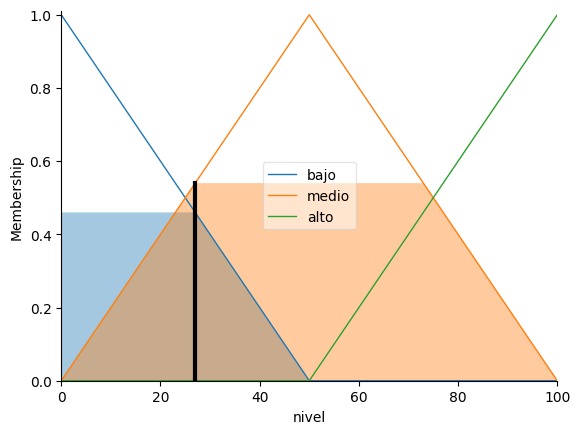

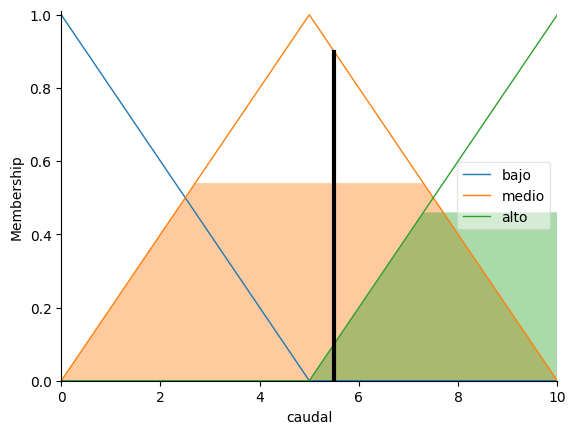

In [14]:
nivel_entrada.view(sim=simulador_caudal)
caudal_salida.view(sim=simulador_caudal)


Por último, y para ver la utilidad práctica del sistema, podemos simular cómo funcionaría nuestro controlador a lo largo del tiempo con el siguiente código:

In [15]:
minutos_simulacion = 20
nivel_actual  = 0
caudal_actual = 0

niveles  = np.zeros(minutos_simulacion)
caudales = np.zeros(minutos_simulacion)
tiempos  = np.arange(0,minutos_simulacion,1)

for t in tiempos:
    # Asignamos los valores a las entradas
    simulador_caudal.input['nivel'] = nivel_actual

    # Ejecutamos .compute() para que haga los cálculos
    simulador_caudal.compute()

    # Obtenemos las salidas
    caudal_actual = simulador_caudal.output['caudal']

    # Guardamos los datos para mostrarlos posteriormente
    niveles[t]  = nivel_actual
    caudales[t] = caudal_actual

    # Asumiendo un funcionamiento 'instantáneo', y al ser cada iteración 1 minuto, el nivel subirá lo 'ordenado' por el controlador para la próxima iteración
    nivel_actual = nivel_actual + caudal_actual

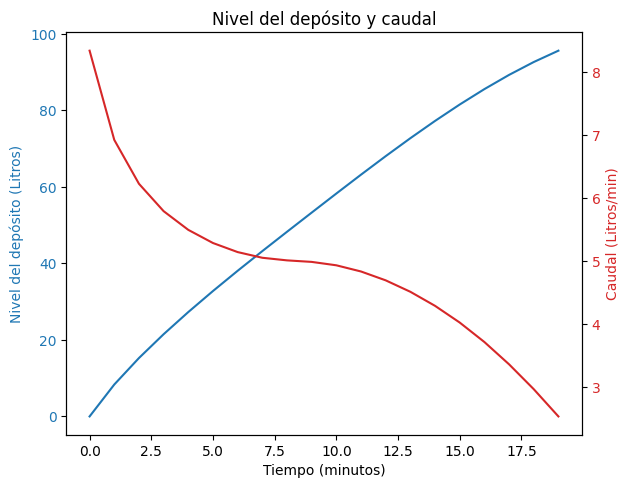

In [16]:

# Mostramos los resultados
fig, ax1 = plt.subplots()

ax1.set_xlabel('Tiempo (minutos)')
ax1.set_ylabel('Nivel del depósito (Litros)', color='tab:blue')
ax1.plot(tiempos, niveles, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Caudal (Litros/min)', color='tab:red')
ax2.plot(tiempos, caudales, color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.title('Nivel del depósito y caudal')
plt.show()

## 3. Ejercicios



### 3.1. Riesgo de incendios



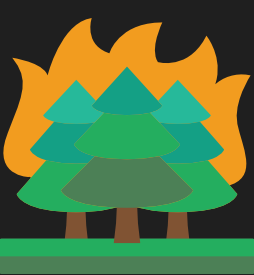

Cree un sistema de clasificación difusa para evaluar el nivel de riesgo de incendio basado en dos entradas: "temperatura" y "humedad". El sistema tendrá las siguientes características:

   - El rango de temperaturas será de 0 a 50 grados.
   - El rango de humedad relativa será de 0 a 100%.
   - El nivel de riesgo resultante se medirá en una escala de 0 a 100.

Las reglas a implementar son:
   - Si la temperatura es alta y la humedad baja el riesgo es alto.
   - Si la humedad es alta o la temperatura es baja, el riesgo es bajo.
   - Si la humedad es media o la temperatura es media, el riesgo es medio.

Defina los conjuntos de temperatura y humedad como considere, pero teniendo claro lo siguiente:
- A partir de 30 grados ya se considera la temperatura como alta con seguridad.
- Por debajo del 30% se considera una humedad relativa como baja con seguridad.

Visualice los conjuntos difusos empleados en antecedentes y consecuentes. Obtenga nieveles de riesgo para las siguientes entradas:

- Temperatura: 40 ºC, humedad: 10%
- Temperatura: 40ºC, humedad: 60%
- Temperatura: 15ºC, humedad: 10%

**SOLUCIÓN**

Para una temperatura 40ºC y una humedad del 10%, el nivel de riesgo es 80.55555555555556
Para una temperatura 40ºC y una humedad del 60%, el nivel de riesgo es 22.023809523809522
Para una temperatura 15ºC y una humedad del 10%, el nivel de riesgo es 35.65789473684211


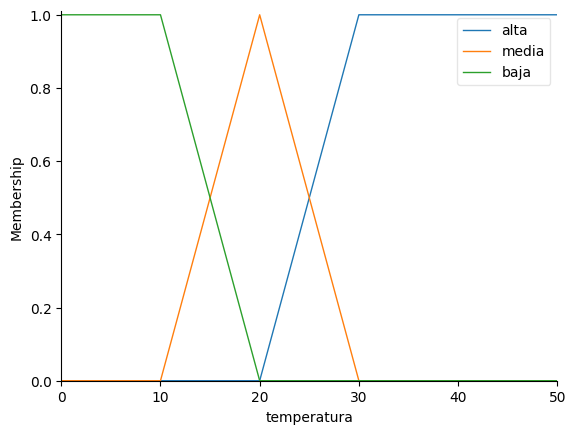

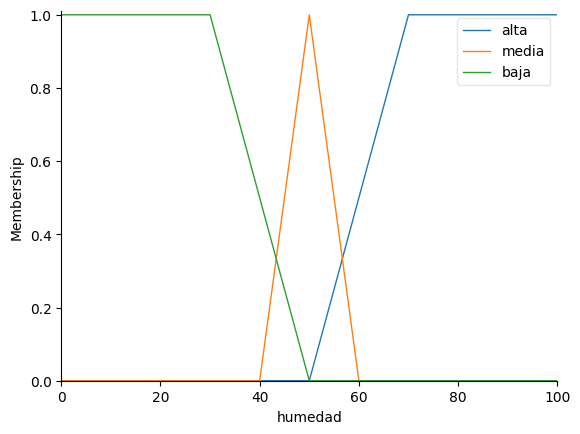

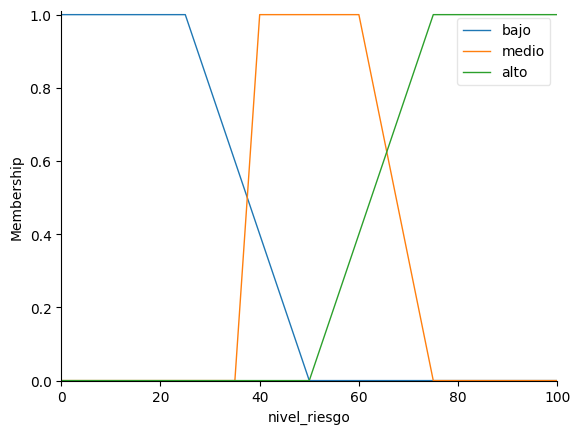

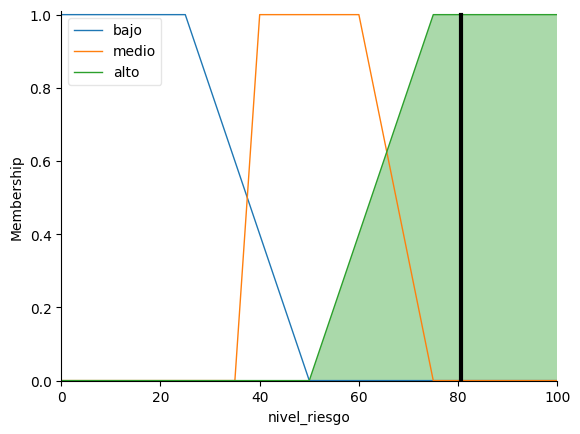

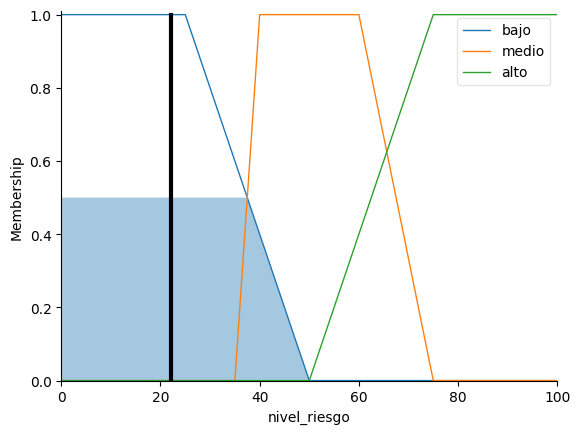

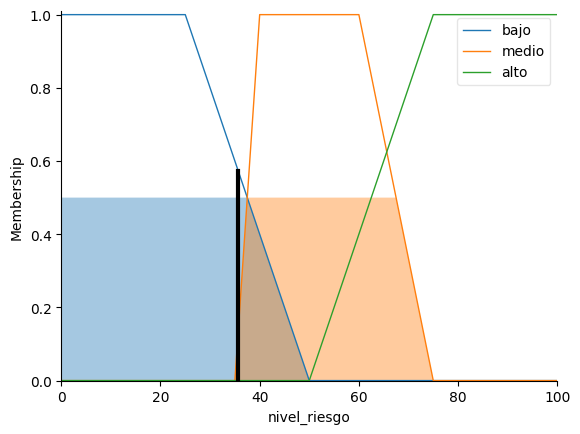

In [17]:
#Definir los rangos y los conjuntos de pertenencia de temperatura y humedad
temperatura =
humedad =

temperatura_baja =
temperatura_media =
temperatura_alta =

humedad_alta =
humedad_media =
humedad_baja= 

# Definir las variables de entrada para temperatura y humedad
temperatura_input = 
humedad_input = 

# Definir las funciones de membresía para el nivel de riesgo.
# Podemos definir el universo de dicho nivel directamente al definir el consecuente
# y luego usarlo para definir los conjuntos
nivel_riesgo = 
nivel_riesgo['bajo'] = 
nivel_riesgo['medio'] = 
nivel_riesgo['alto'] = 

# Asignar las funciones de membresía a las variables de entrada
temperatura_input['alta'] = 
temperatura_input['media'] = 
temperatura_input['baja'] = 

humedad_input['alta'] = 
humedad_input['media'] = 
humedad_input['baja'] = 

# Visualizar las funciones de pertenencia
temperatura_input.view()
humedad_input.view()
nivel_riesgo.view()

# Definir las reglas difusas
rule1 = 
rule2 = 
rule3 = 

# Crear el sistema de control difuso
sistema_riesgo = 
nivel_riesgo_prediccion = 

# Prueba de funcionamiento
valores_test_temperatura = [40,40,15]
valores_test_humedad = [10,60,10]
for i in range(0,len(valores_test_temperatura)):
    nivel_riesgo_prediccion.input['temperatura']=valores_test_temperatura[i]
    nivel_riesgo_prediccion.input['humedad']=valores_test_humedad[i]
    nivel_riesgo_prediccion.compute()
    print(f"Para una temperatura {valores_test_temperatura[i]}ºC y una humedad del {valores_test_humedad[i]}%, el nivel de riesgo es {nivel_riesgo_prediccion.output['nivel_riesgo']}")
    nivel_riesgo.view(sim=nivel_riesgo_prediccion)

### 3.2. Regalator

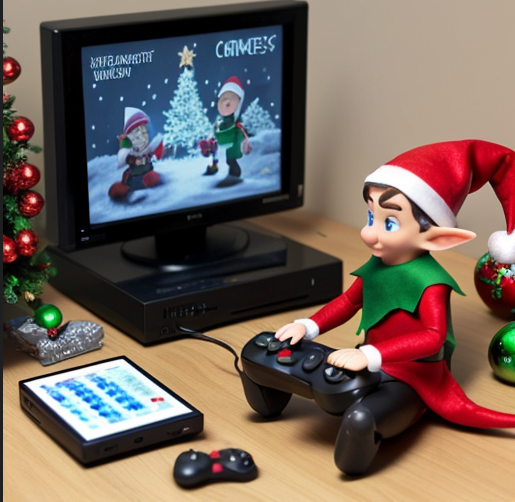

<small>_Fuente de la imagen: Stable Diffusion_</small>

Los elfos de Papá Noel se están preparando para la próxima campaña. Papá Noel está totalmente colapsado decidiendo los regalos de los niños y las niñas de todo el mundo, así que ha pedido ayuda a los elfos, y les ha dado las siguientes reglas:

- Si se ha portado **muy** bien en el cole y ha ayudado a los demás lo normal **o** mucho, se merece una videoconsola.
- Si ha **no** ha obedecido poco a sus padres, le podemos regalar un juguete.
- Si se ha portado **muy** mal en el cole, ha obedecido **muy** poco a sus padres, y ha ayudado **muy** poco a los demás, le regalaremos carbón.

Afortunadamente, uno de los elfos ha estudiado un Grado en Ciencias de Datos y propone diseñar un controlador difuso, al que llamará `Regalator`, para estimar el precio a invertir en cada regalo, de 0 a 500 euros. Gracias a una colaboración con las grandes tecnológicas, los elfos tienen un ranking de 0 a 10 de cada niño y niña en las tres características (comportamiento en cole, obediencia a padres, ayuda a los demás). Ayude a los elfos proponiendo un sistema de control difuso que, dado el valor de las tres características, devuelva el coste sugerido para el regalo.

Asumiremos los siguientes precios:
- En carbón como mucho gastaríamos 50 euros.
- Juguetes pueden encontrarse con valores de 20 a 200 euros.
- Una videoconsola puede costar desde 150 euros (segunda mano) hasta 500 euros.

Muestre las funciones de pertenencia usadas en las entradas y en la salida.

Para probarlo, obtenga el precio de regalo estimado para estos tres sujetos:

| Niño/a         | Comportamiento  | Obediencia  | Ayuda       |
|----------------|-----------------|-------------|-------------|
| Paulita        |    10           |  7          |   7         |
| Alvarito       |    3            | 5           |   8         |
| Sarita         |    1            | 0           |   1         |

In [18]:
# En primer lugar hay que definir los rangos (universo) para cada variable
# Los tres "sensores" tienen un rango de 0 a 10, por lo que podemos definir sólo uno
sensor = 
precio = 

# Definir los conjuntos difusos

# Comportamiento en el cole
comportamiento_bueno =
comportamiento_normal = 
comportamiento_malo = 

# Obediencia a los padres
obediencia_mucha = 
obediencia_normal = 
obediencia_poca = 

# Ayuda a los demás
ayuda_mucho = 
ayuda_normal = 
ayuda_poco = 

# Niveles del consecuente. 
# -  Suponemos que a partir de 200 e se puede comprar una consola (de 2a mano o así)
# -  Suponemos que hay juguetes desde los 0 e, aunque la mayoría están en el rango de los 50-150, y como mucho 200
# -  Más de 50 euros en carbón no lo vemos posible
precio_videoconsola =
precio_juguete = 
precio_carbon = 

## Definimos los antecedentes y consecuentes de las reglas
entrada_comportamiento = 
entrada_obediencia = 
entrada_ayuda = 
salida_precio = 

# Asociamos/Definimos las funciones de pertenencia para cada etiqueta lingüistica que vayamos a necesitar en las reglas
# NOTA: cuidado los modificadores lingüisticos de los conjuntos

# Entrada de comportamiento

# Entrada de obediencia

# Entrada de ayuda

# Asociamos las funciones de pertenencia para cada etiqueta lingüistica de la salida

# Implementamos las reglas de Papá Noel
regla1 = 
regla2 = 
regla3 = 

# Crear el sistema de control y simularlo
regalator_ctrl = 
regalator = 

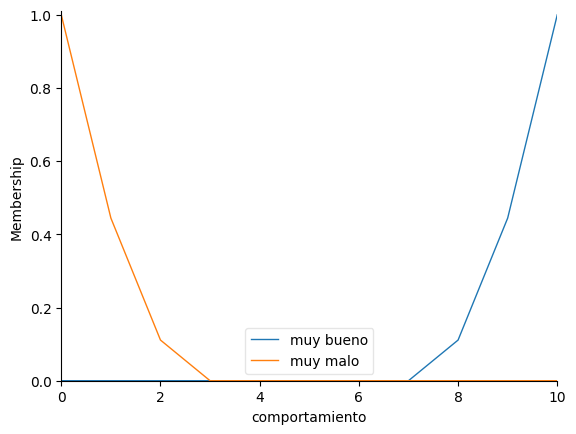

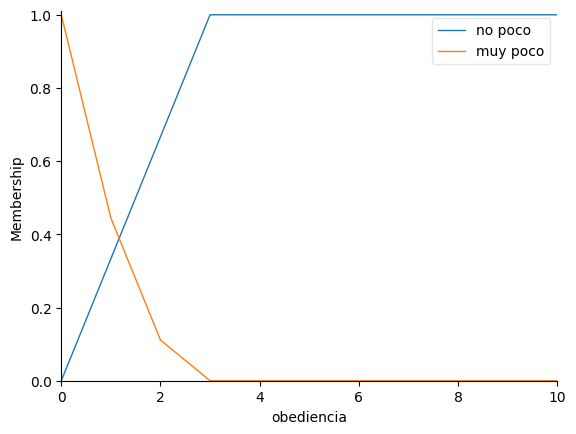

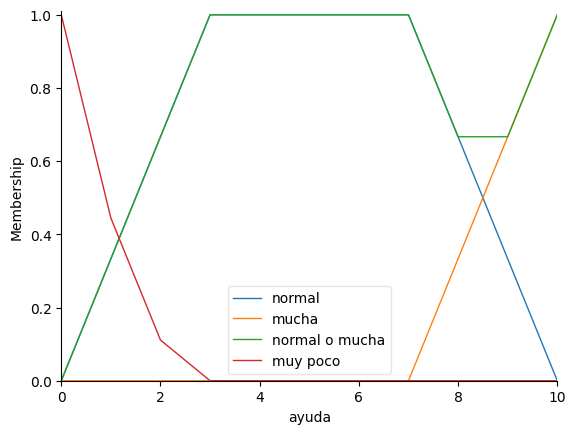

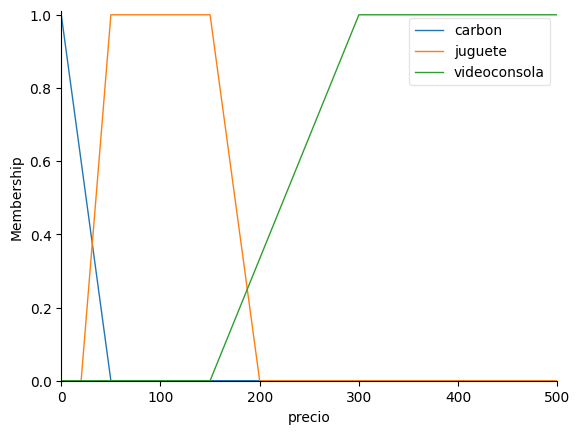

In [19]:
# Para mostrar las funciones de pertenencia
entrada_comportamiento.view()
entrada_obediencia.view()
entrada_ayuda.view()

salida_precio.view()

Sujeto Paulita: 274.97635085544664 euros


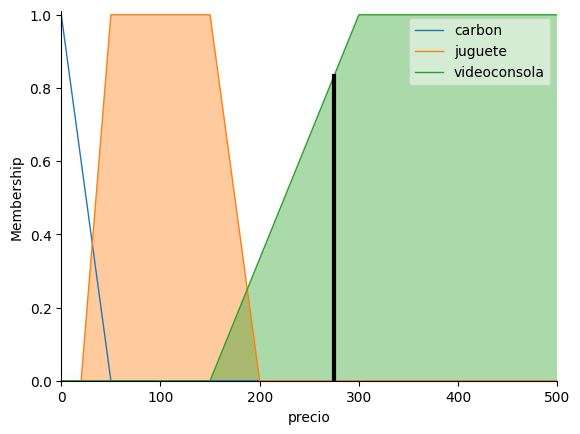

Sujeto Alvarito: 105.47619047619045 euros


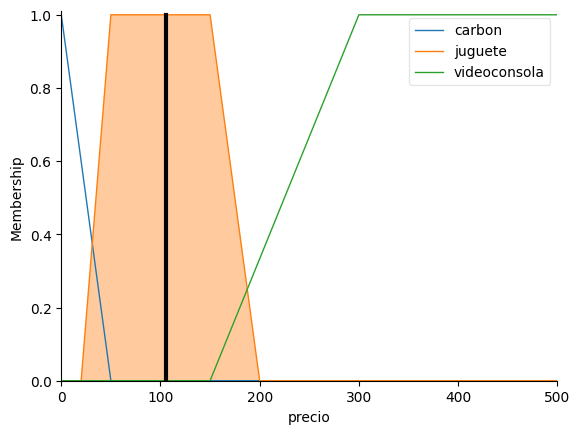

Sujeto Sarita: 19.973544973544968 euros


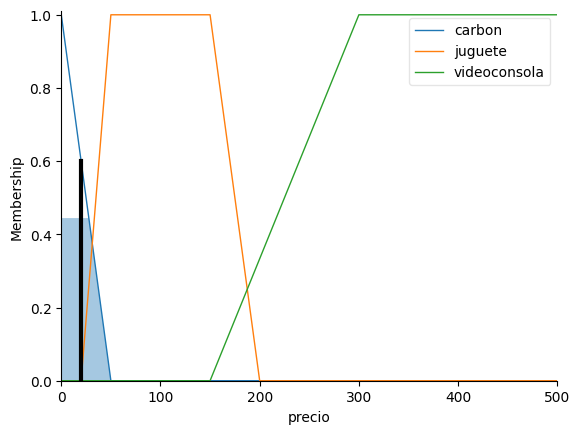

In [20]:
# Valoración de los distintos sujetos:
sujeto = ['Paulita','Alvarito','Sarita']
comportamiento = [10,3,1]
obediencia = [7,5,0]
ayuda = [7,8,1]

for i in range(0,len(sujeto)):
    regalator.input['comportamiento'] = comportamiento[i]
    regalator.input['obediencia'] = obediencia[i]
    regalator.input['ayuda'] = ayuda[i]
    regalator.compute()
    regalo = regalator.output['precio']

    print(f"Sujeto {sujeto[i]}: {regalo} euros")
    salida_precio.view(sim=regalator)
    plt.show()